<a href="https://colab.research.google.com/github/rsrikrishnan27/DS/blob/main/Hello_Watson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypothesis testing using NLI - LSTM and Bi-directional LSTM

In [ ]:
## Install the necessary libraries

import numpy as np 
import pandas as pd 

import re
import nltk
from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import keras
from tensorflow.math import softplus, tanh
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Embedding, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
import torch
import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# importing Data
df = pd.read_csv('nli_watson.csv')

In [ ]:
df

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


## Some EDA

In [ ]:
Accuracy=pd.DataFrame()
Accuracy['Type']= df.label.value_counts().index
Accuracy['Count']= df.label.value_counts().values
Accuracy['Type']=Accuracy['Type'].replace(0,'Entailment')
Accuracy['Type']=Accuracy['Type'].replace(1,'Neutral')
Accuracy['Type']=Accuracy['Type'].replace(2,'Contradiction')
Accuracy

,Type,Count
0,Entailment,4176
1,Contradiction,4064
2,Neutral,3880


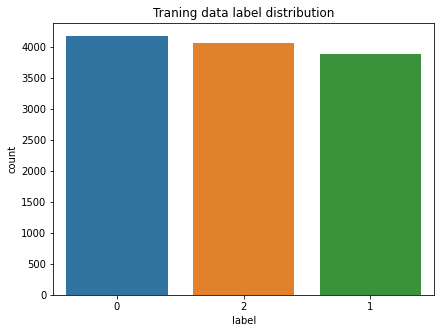

In [ ]:
fig = plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.title('Traning data label distribution')
sns.countplot(data = df, x = 'label', order = df['label'].value_counts().index[:10])
plt.show()

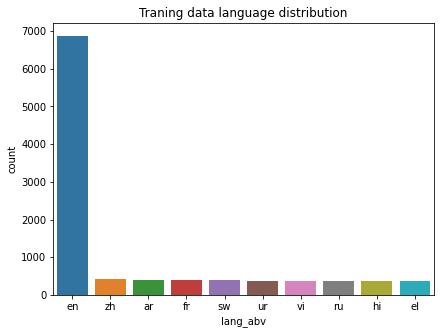

In [ ]:
fig = plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.title('Traning data language distribution')
sns.countplot(data = df, x = 'lang_abv', order = df['lang_abv'].value_counts().index[:10])

plt.show()

In [ ]:
import string

Meta_features = pd.DataFrame()

## Number of words in the text ##
Meta_features["premise_num_words"] = df["premise"].apply(lambda x: len(str(x).split()))
Meta_features["hypothesis_num_words"] = df["hypothesis"].apply(lambda x: len(str(x).split()))

## Number of characters in the text ##
Meta_features["premise_num_chars"] = df["premise"].apply(lambda x: len(str(x)))
Meta_features["hypothesis_num_chars"] = df["hypothesis"].apply(lambda x: len(str(x)))

## Number of punctuations in the text ##
Meta_features["premise_num_punctuations"] =df["premise"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
Meta_features["hypothesis_num_punctuations"] =df["hypothesis"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Average length of the words in the text ##
Meta_features["premise_mean_word_len"] = df["premise"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
Meta_features["hypothesis_mean_word_len"] = df["hypothesis"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

Meta_features['label'] = df['label']

In [ ]:
Meta_features

,premise_num_words,hypothesis_num_words,premise_num_chars,hypothesis_num_chars,premise_num_punctuations,hypothesis_num_punctuations,premise_mean_word_len,hypothesis_mean_word_len,label
0,10,14,68,81,1,1,5.900000,4.857143,0
1,15,10,81,58,2,1,4.400000,4.900000,2
2,15,4,92,37,3,3,5.200000,8.500000,0
3,17,8,92,50,1,2,4.470588,5.375000,0
4,6,1,182,47,0,0,29.500000,47.000000,1
...,...,...,...,...,...,...,...,...,...
12115,35,10,247,56,3,1,6.085714,4.700000,2
12116,25,16,140,80,4,2,4.600000,4.062500,0
12117,14,7,69,32,2,2,4.000000,3.714286,2
12118,13,9,64,44,1,1,4.000000,4.000000,2


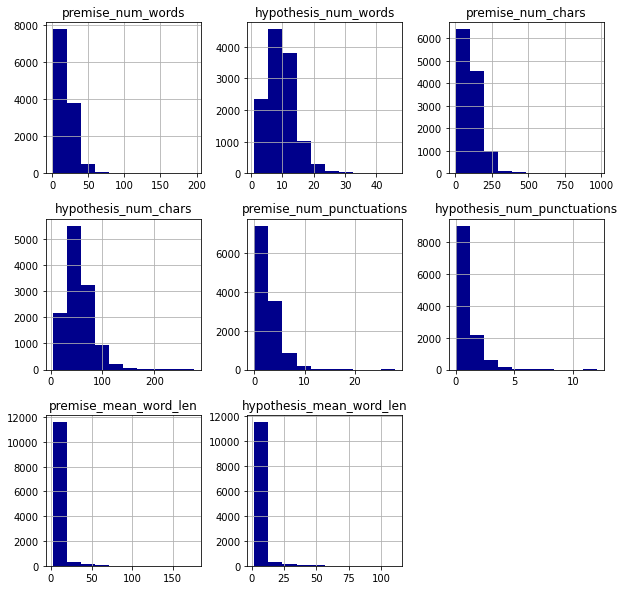

In [ ]:
ft = Meta_features.drop(['label'],axis = 1)
a = ft.hist(figsize = (10,10),color = "darkblue")
plt.show()

In [ ]:
text_df = df.copy()

In [ ]:
nltk.download('stopwords')
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

text_df['premise'] =  text_df['premise'].apply(clean_sentence)
text_df['hypothesis'] =  text_df['hypothesis'].apply(clean_sentence)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
text_df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,comments considered formulating interim rules,rules developed interim put together comments ...,en,English,0
1,5b72532a0b,issues wrestle practice groups law firms said,practice groups permitted work issues,en,English,2
2,3931fbe82a,petites choses comme celleslà font différence ...,jessayais daccomplir quelque chose,fr,French,0
3,5622f0c60b,know cant really defend like somebody grown uh...,cant defend age,en,English,0
4,86aaa48b45,ในการเลนบทบาทสมมตกเชนกน โอกาสทจะไดแสดงออกและได...,เดกสามารถเหนไดวาชาตพนธแตกตางกนอยางไร,th,Thai,1


In [ ]:
def build_corpus(data):
    corpus = []
    for col in ['premise', 'hypothesis']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

text_df_1 = text_df[text_df['lang_abv'] == 'en']

corpus = build_corpus(text_df_1) 

TSNE(t-Distributed Stochastic Neighbor Embedding) is a non-linear dimensionality reduction algorithm used for exploring high-dimensional data. The idea is to keep similar words close together on the plane, while maximizing the distance between dissimilar words

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16,16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

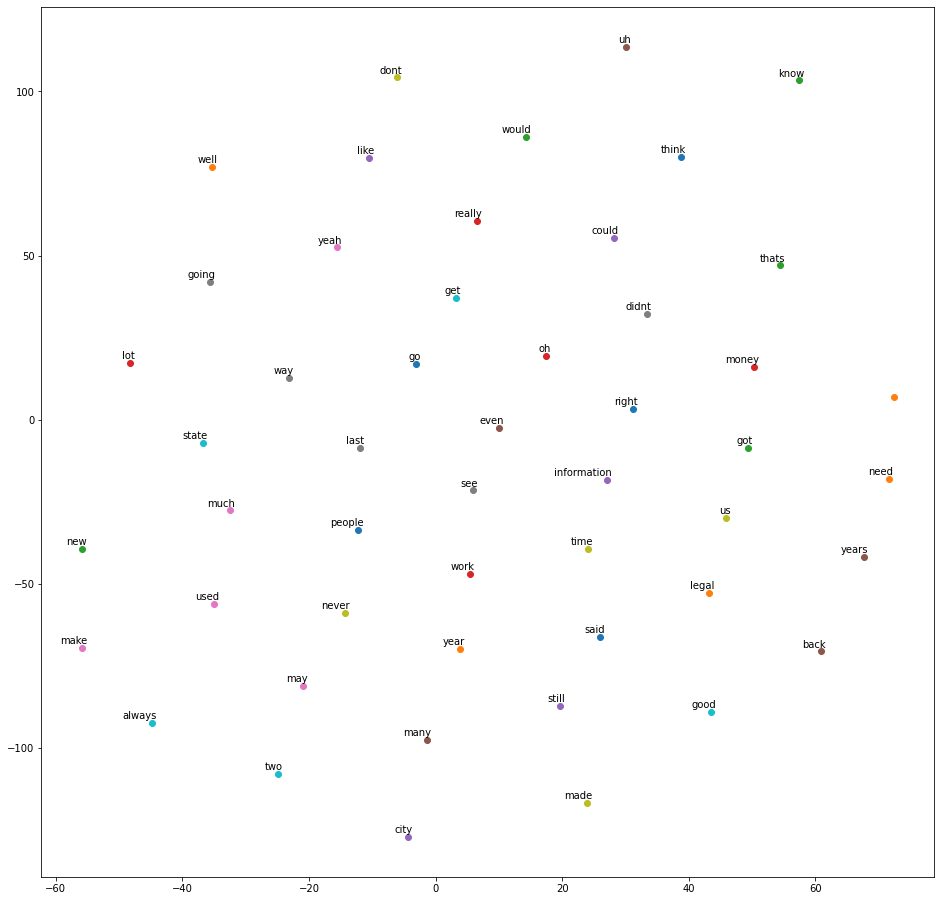

In [ ]:
model = word2vec.Word2Vec(corpus, size=100, window=200, min_count=150, workers=4)
tsne_plot(model)

## Data Cleaning and Pre-processing

In [ ]:
# Text Cleaning

from nltk.corpus import stopwords
import re
import nltk
import string


stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:     #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in df['premise']:
    cleaned_text.append(text_cleaner(t))
df['premise'] = cleaned_text   

cleaned_text = []
for t in df['premise']:
    cleaned_text.append(text_cleaner(t))
df['premise'] = cleaned_text 

cleaned_text = []
for t in df['hypothesis']:
    cleaned_text.append(text_cleaner(t))
df['hypothesis'] = cleaned_text   

cleaned_text = []
for t in df['hypothesis']:
    cleaned_text.append(text_cleaner(t))
df['hypothesis'] = cleaned_text 

In [ ]:
tfidf_vec = TfidfVectorizer(analyzer='word',ngram_range = (1,3),max_features=1000)

In [ ]:
X1 = df[df['lang_abv']=='en']

In [ ]:
y = X1['label']
X = X1.drop(['label','id','lang_abv','language'],axis = 1)

In [ ]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("TPU is on!")
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
vocab_size = 10000
oov_tok = '<OOV>'
emb_dim = 32
max_len = 250

In [ ]:
# Text vectorizer

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

In [ ]:
X_train['combined'] = X_train['premise'] + ' [SEP] ' + X_train['hypothesis']

In [ ]:
x = X_train['combined']

Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary

In [ ]:
tokenizer.fit_on_texts(x)
train_seq = tokenizer.texts_to_sequences(x)
padded_train = pad_sequences(train_seq, maxlen = max_len)

In [ ]:
print(x[0])

comments considered formulating interim rules [SEP] rules developed interim put together comments mind


In [ ]:
print(padded_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
X_test['combined'] = X_test['premise'] + ' [SEP] ' + X_test['hypothesis']
x_test = X_test['combined']
test_seq = tokenizer.texts_to_sequences(x_test)
padded_test = pad_sequences(test_seq, maxlen = max_len)

In [ ]:
y_train = pd.DataFrame(y_train)
y_train = pd.get_dummies(y_train['label'])
y_train.head()

,0,1,2
5538,1,0,0
4267,1,0,0
12001,1,0,0
10938,0,1,0
1844,1,0,0


## LSTM - one directional 

Here we add embedding layer. 
Embedding layer can learn long-term dependencies between time steps of sequence data. A word embedding layer maps a sequence of word indices to embedding vectors and learns the word embedding during training

In [ ]:
# Building model 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, output_dim=emb_dim, input_length=max_len))
model.add(tf.keras.layers.LSTM(16, return_sequences=True))
model.add(tf.keras.layers.LSTM(32,))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 250, 16)           3136      
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 5

In [ ]:
# Model compilation 

model.compile(optimizer=tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(padded_train,y_train, epochs = 20,validation_split = 0.1)

Epoch 1/20
145/145 [==============================] - 29s 167ms/step - loss: 1.0988 - accuracy: 0.3412 - val_loss: 1.0979 - val_accuracy: 0.3508
Epoch 2/20
145/145 [==============================] - 23s 157ms/step - loss: 1.0950 - accuracy: 0.3604 - val_loss: 1.0989 - val_accuracy: 0.3508
Epoch 3/20
145/145 [==============================] - 24s 163ms/step - loss: 1.0311 - accuracy: 0.4767 - val_loss: 1.1486 - val_accuracy: 0.3663
Epoch 4/20
145/145 [==============================] - 24s 165ms/step - loss: 0.8055 - accuracy: 0.6495 - val_loss: 1.3302 - val_accuracy: 0.3333
Epoch 5/20
145/145 [==============================] - 23s 160ms/step - loss: 0.5779 - accuracy: 0.7798 - val_loss: 1.8030 - val_accuracy: 0.3295
Epoch 6/20
145/145 [==============================] - 23s 159ms/step - loss: 0.3965 - accuracy: 0.8568 - val_loss: 2.1720 - val_accuracy: 0.3372
Epoch 7/20
145/145 [==============================] - 23s 158ms/step - loss: 0.2886 - accuracy: 0.8999 - val_loss: 2.6863 - val_ac

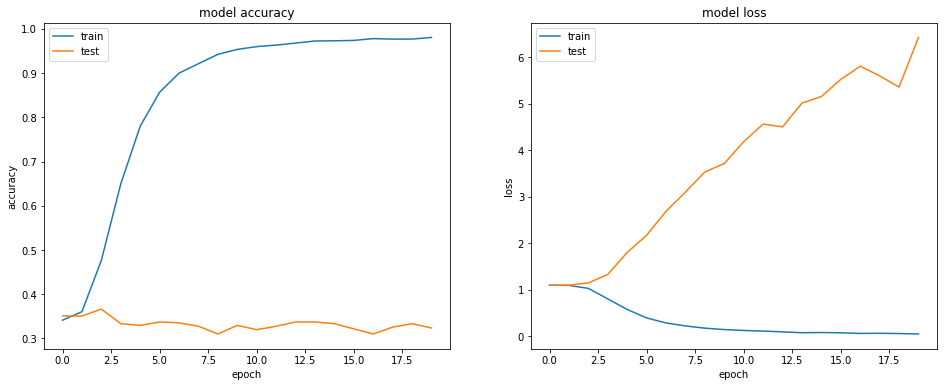

In [ ]:
## Accuracy & Loss plot

plt.figure(figsize = (16,6))

# summarize history for accuracy

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()


In [ ]:
predict_x=model.predict(padded_test) 
prediction=np.argmax(predict_x,axis=1)

In [ ]:
cm1 = confusion_matrix(y_test, prediction)
cm1

array([[138, 214, 251],
       [174, 168, 187],
       [202, 199, 185]])

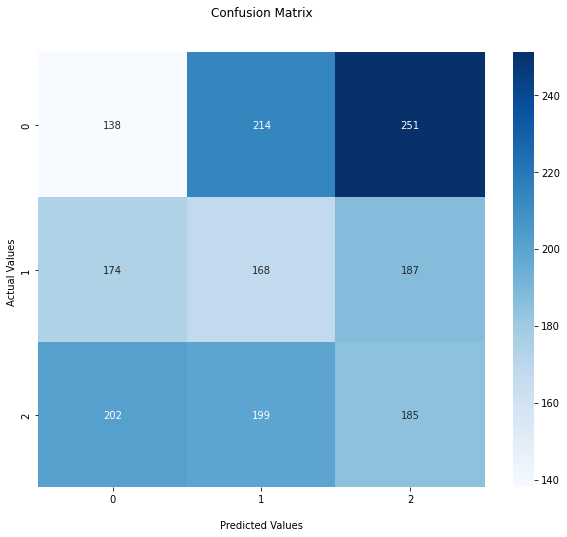

In [ ]:
plt.rcParams["figure.figsize"] = (10,8)
ax = sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## labels 
plt.show()

In [ ]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.27      0.23      0.25       603
           1       0.29      0.32      0.30       529
           2       0.30      0.32      0.31       586

    accuracy                           0.29      1718
   macro avg       0.28      0.29      0.29      1718
weighted avg       0.28      0.29      0.28      1718



## LSTM - Bi-directional

Bidirectional long-short term memory(bi-lstm) is the process of making any neural network to have the sequence information in both directions backwards (future to past) or forward (past to future)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, output_dim=emb_dim, input_length=max_len))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dense(vocab_size/2, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 32)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 250, 300)         219600    
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 250, 300)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               160400    
                                                                 
 dense_2 (Dense)             (None, 5000)              505000    
                                                                 
 dropout_3 (Dropout)         (None, 5000)              0         
                                                      

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(padded_train,y_train, epochs = 10, validation_split = 0.3)

Epoch 1/10
113/113 [==============================] - 96s 807ms/step - loss: 1.2688 - accuracy: 0.3469 - val_loss: 1.0993 - val_accuracy: 0.3150
Epoch 2/10
113/113 [==============================] - 88s 778ms/step - loss: 1.0985 - accuracy: 0.3500 - val_loss: 1.0979 - val_accuracy: 0.3577
Epoch 3/10
113/113 [==============================] - 89s 792ms/step - loss: 1.1022 - accuracy: 0.3478 - val_loss: 1.1040 - val_accuracy: 0.3551
Epoch 4/10
113/113 [==============================] - 88s 779ms/step - loss: 1.0733 - accuracy: 0.4088 - val_loss: 1.1140 - val_accuracy: 0.3642
Epoch 5/10
113/113 [==============================] - 88s 783ms/step - loss: 0.9722 - accuracy: 0.4947 - val_loss: 1.1671 - val_accuracy: 0.3499
Epoch 6/10
113/113 [==============================] - 86s 765ms/step - loss: 0.7783 - accuracy: 0.5865 - val_loss: 1.3320 - val_accuracy: 0.3583
Epoch 7/10
113/113 [==============================] - 88s 783ms/step - loss: 0.6433 - accuracy: 0.6378 - val_loss: 1.6373 - val_ac

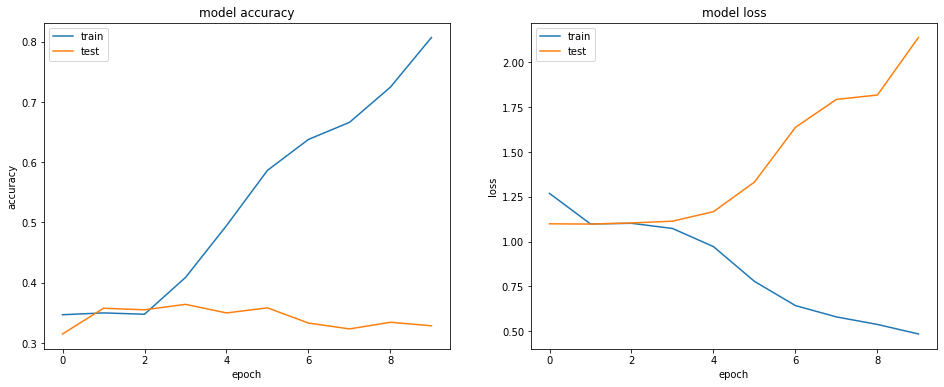

In [ ]:
plt.figure(figsize = (16,6))

# summarize history for accuracy

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()


In [ ]:
# prediction = model.predict_classes(padded_test)
# prediction
predict_x=model.predict(padded_test) 
prediction=np.argmax(predict_x,axis=1)

In [ ]:
cm1 = confusion_matrix(y_test, prediction)
cm1

array([[359, 142, 102],
       [314, 136,  79],
       [328, 160,  98]])

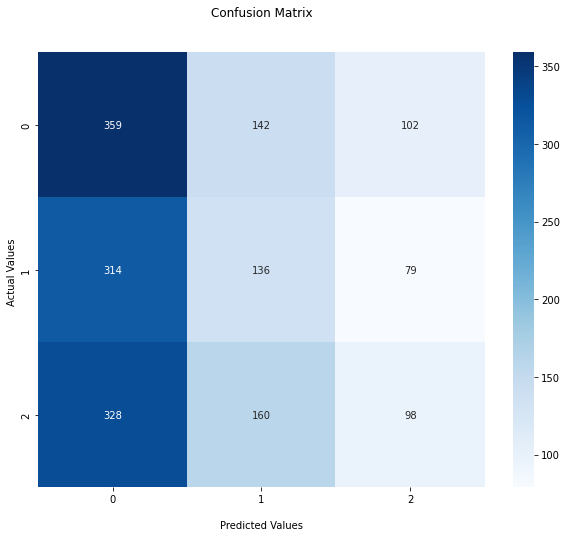

In [ ]:
plt.rcParams["figure.figsize"] = (10,8)
ax = sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## labels 
plt.show()

In [ ]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.36      0.60      0.45       603
           1       0.31      0.26      0.28       529
           2       0.35      0.17      0.23       586

    accuracy                           0.35      1718
   macro avg       0.34      0.34      0.32      1718
weighted avg       0.34      0.35      0.32      1718



From the model results, we see that bi-directional LSTM performs better than ordinary LSTM

### Refernces:

* https://analyticsindiamag.com/lstm-vs-gru-in-recurrent-neural-network-a-comparative-study/

* https://medium.com/analytics-vidhya/rnn-vs-gru-vs-lstm-863b0b7b1573

* https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/





